In [1]:
import numpy as np
import pandas as pd
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
import pydot
from IPython.display import SVG
from sklearn.model_selection import train_test_split
import keras.backend as K
K.set_image_data_format('channels_last')
import math
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import keras
import matplotlib.pyplot as plt

from normalize import *

In [2]:
def get_data():
    # Load Data
    # We load data into RAM since data is small and will fit in memory.
    cells = pd.read_csv("tumor_cycif.csv")
    
    # Keeps only the 'interesting' columns.
    cells = cells.filter(regex="Cell Masks$", axis=1).filter(regex="^(?!(Goat|DAPI))", axis=1)
    cells = np.array(cells)
    
    return cells

In [3]:
cells = get_data()

# Number of cells
assert cells.shape[0] == 12142
# Number of features per input
assert cells.shape[1] == 25

In [4]:
# Two options for normalization:
# 1- use the following;
# 2- use StandardScaler append to the estimators. 
#
# My experiments show that option one results to 
# a much lower MAE (~6k vs ~0.05). 
cells = normalize(cells)

### Separate one of the markers as target 

In [5]:
def xy_split(cells, idx):
    y = cells[:, idx]
    # This reshape can simplify broadcasting.
    y = y.reshape(y.shape[0], 1)
    
    # `1` means delete column, while `0` means delete row.
    X = np.delete(cells, idx, 1)
    return X, y

# The index of the marker column 
# whose values will be predicted 
# using other markers.
idx = 10

X, y = xy_split(cells, idx)

input_dim = X.shape[1]

In [6]:
def baseline_model():
    inputs = keras.Input(shape=(input_dim))
    h1 = layers.Dense(input_dim, activation="relu", kernel_initializer="normal")(inputs)
    outputs = layers.Dense(1, kernel_initializer="normal")(h1)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0005), loss="mean_squared_error", metrics=['mae'])
    return model

## k-Fold Cross-Validation

In [7]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
# mlp: Multilayer Perceptron
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)

#history = pipeline.fit(X, y)

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
results = cross_val_score(pipeline, X, y, cv=kfold)

print(f"MSE's: {results}")
print(f"Baseline: {results.mean()} ({results.std()}) MSE")

MSE's: [-0.05159922 -0.05144814 -0.05881842 -0.06310532 -0.05594909 -0.04519513
 -0.04568515 -0.06117691 -0.05211247 -0.05966164]
Baseline: -0.054475147649645804 (0.0059475093220116015) MSE


## Train the Model

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1, shuffle=True)
regressor = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
history = regressor.fit(X_train, y_train, epochs=50, batch_size=5)

In [9]:
print(history.history.keys())

dict_keys(['loss', 'mae'])


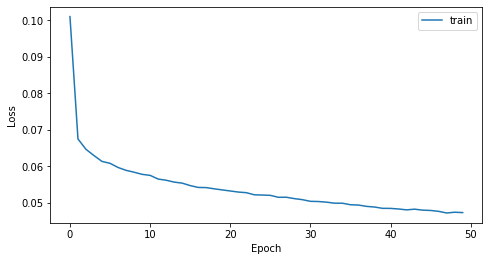

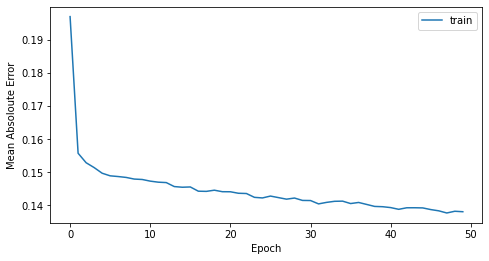

In [12]:
def plot(train, x_label):
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(train, label='train')
    plt.xlabel('Epoch')
    plt.ylabel(x_label)
    plt.legend(loc='upper right')
    plt.show()

# Plot loss
plot(history.history['loss'], "Loss")
plot(history.history['mae'], "Mean Absoloute Error")
#plot(history.history['mae'], history.history['val_mae'], "Mean Absolute Error")

In [13]:
idx_validation_cell = 22
validation_cell = X_val[idx_validation_cell,:].reshape(1, X_val.shape[1])
prediction = regressor.predict(validation_cell)
print(f"   Actual value: {y_val[idx_validation_cell][0]}")
print(f"Predicted value: {prediction}")

   Actual value: -0.6244806786550537
Predicted value: -0.6985435485839844
